# Make MAXMAGS search hits constraint data file

This uses the [contour constraint data](https://occweb.cfa.harvard.edu/twiki/pub/Aspect/PeaMaxMagTesting/PEA_MAXMAG_testing_2021_03_contour_data.txt) generated by Mark Baski in 
[PeaMaxMagTesting](https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/PeaMaxMagTesting)
to generate a data file `maxmags.dat` for use in `proseco` in acquisition star selection.

In [1]:
from typing import List
from astropy.table import Table
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.style
from dataclasses import dataclass
matplotlib.style.use('bmh')
%matplotlib inline

In [2]:
dat = Table.read("maxmags.dat", format="ascii")

In [3]:
dg = dat.group_by('maxmag')  # type: Table

In [4]:
@dataclass
class Line:
    x: List[float]
    y: List[float]
    z: List[float]

    def __post_init__(self):
        self.x = np.asarray(self.x)
        self.y = np.asarray(self.y)
        self.z = np.asarray(self.z)

In [5]:
lines = []  # type: List[Line]
for grp in dg.groups:
    line = Line(x=grp['ccd_temp'], y=grp['box_sz'], z=grp['maxmag'])
    lines.append(line)

In [6]:
line_left = Line(
    x=[-10, -10, -10], 
    y=[60, 200, 240], 
    z=[11.2, 11.2, 11.1])
line_bottom = Line(
    x=[-10, -3.25, -1.5, 0], 
    y=[60, 60, 60, 60], 
    z=[11.2, 11.2, 11.0, 10.9])
line_top = Line(
    x=[-10, -8.8, -6.5, -5.0, -1.75, 0],
    y=[240, 240, 240, 240, 240, 240],
    z=[11.1, 11.0, 10.8, 10.6, 10.4, 10.3])
line_right = Line(
    x=[0, 0, 0, 0, 0],
    y=[60, 67.6, 85.0, 148.6, 240],
    z=[10.9, 10.8, 10.6, 10.4, 10.3])

In [7]:
lines[0]

Line(x=array([-1.7561, -0.7537, -0.3973,  0.    ]), y=array([240.    , 180.    , 160.    , 148.5714]), z=array([10.4, 10.4, 10.4, 10.4]))

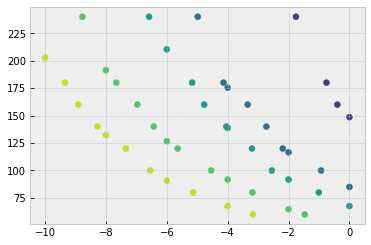

In [8]:
for line in lines:
    plt.scatter(line.x, line.y, c=line.z, vmin=10.2, vmax=11.3)

In [9]:
def interp_vline(lines, xi: float, yi: List[float]):
    ys = []
    zs = []
    for line in lines + [line_bottom, line_top]:
        if xi >= min(line.x) and xi <= max(line.x):
            idx = np.argsort(line.x)
            # x value where yi intersects this line
            y = np.interp(xi, line.x[idx], line.y[idx])
            ys.append(y)
            # z value at the intersection of yi and this line
            z = np.interp(xi, line.x[idx], line.z[idx])
            zs.append(z)

    idx = np.argsort(ys)
    ys = np.array(ys)[idx]
    zs = np.array(zs)[idx]

    z_out = np.interp(yi, ys, zs)
    return z_out

In [10]:
def interp_hline(lines, xi: List[float], yi: float):
    xs = []
    zs = []
    for line in lines + [line_left, line_right]:
        if yi >= min(line.y) and yi <= max(line.y):
            idx = np.argsort(line.y)
            # x value where yi intersects this line
            x = np.interp(yi, line.y[idx], line.x[idx])
            xs.append(x)
            # z value at the intersection of yi and this line
            z = np.interp(yi, line.y[idx], line.z[idx])
            zs.append(z)

    idx = np.argsort(xs)
    xs = np.array(xs)[idx]
    zs = np.array(zs)[idx]

    z_out = np.interp(xi, xs, zs)
    return z_out

In [11]:
interp_hline(lines, np.arange(-10, 1), 60)

array([11.2       , 11.2       , 11.2       , 11.2       , 11.2       ,
       11.2       , 11.2       , 11.1797268 , 11.06247289, 10.96815703,
       10.9       ])

In [12]:
interp_vline(lines, xi=0, yi=np.arange(60, 241, 20))

array([10.9       , 10.65766422, 10.55285273, 10.48991333, 10.42697394,
       10.38749997, 10.36562498, 10.34374999, 10.32187499, 10.3       ])

In [13]:
t_ccds = np.linspace(-10, 0, 100)
box_szs = np.linspace(60, 240, 60)

In [14]:
hvals = []
for box_sz in box_szs:
    hvals.append(interp_hline(lines, t_ccds, box_sz))
hvals = np.array(hvals)

In [15]:
hvals.shape

(60, 100)

In [16]:
vvals = []
for t_ccd in t_ccds:
    vvals.append(interp_vline(lines, t_ccd, box_szs))
vvals = np.array(vvals)

In [17]:
maxmags = (hvals + vvals.transpose()) / 2

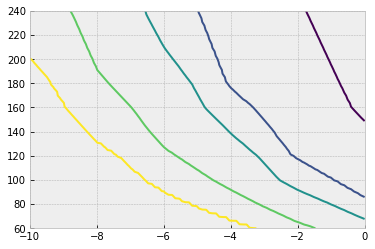

In [18]:
plt.contour(*np.meshgrid(t_ccds, box_szs), 
            maxmags, 
            levels=[10.4, 10.6, 10.8, 11, 11.199]);

In [19]:
out = {}
t_ccds_interp = np.linspace(-10, 0, 101)
out['t_ccds'] = t_ccds_interp
out['box_sizes'] = np.arange(60, 241, 20)
for box_sz in out['box_sizes']:
    box_sz_interp = np.full(shape=len(t_ccds_interp), fill_value=box_sz)
    xi = np.array([box_sz_interp, t_ccds_interp]).transpose()
    z = interpolate.interpn((box_szs, t_ccds), maxmags, xi)
    out[f'vals_{box_sz}'] = z.astype(np.float32)

In [20]:
!rm -f maxmags.npz

In [21]:
np.savez('maxmags.npz', **out)

In [22]:
out2 = np.load('maxmags.npz')

In [23]:
list(out2.keys())

['t_ccds',
 'box_sizes',
 'vals_60',
 'vals_80',
 'vals_100',
 'vals_120',
 'vals_140',
 'vals_160',
 'vals_180',
 'vals_200',
 'vals_220',
 'vals_240']